Best parameters for Decision Tree: {'max_depth': 5, 'max_features': 23}
Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}

Evaluation metrics for Decision Tree:
Confusion Matrix:
[[83 15]
 [ 9 88]]
Precision:
0.8543689320388349
Recall:
0.9072164948453608
Accuracy:
0.8769230769230769
F1 Score:
0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87        98
           1       0.85      0.91      0.88        97

    accuracy                           0.88       195
   macro avg       0.88      0.88      0.88       195
weighted avg       0.88      0.88      0.88       195


Evaluation metrics for K-Nearest Neighbors:
Confusion Matrix:
[[78 20]
 [12 85]]
Precision:
0.8095238095238095
Recall:
0.8762886597938144
Accuracy:
0.8358974358974359
F1 Score:
0.8415841584158417
Classification Report:
              precision    recall  f1-score   support

           0       0.87     

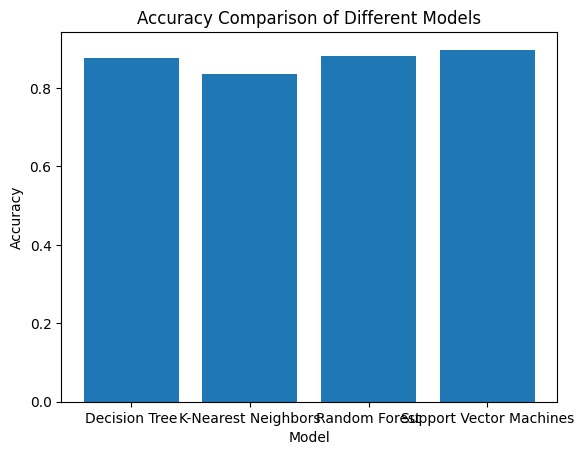

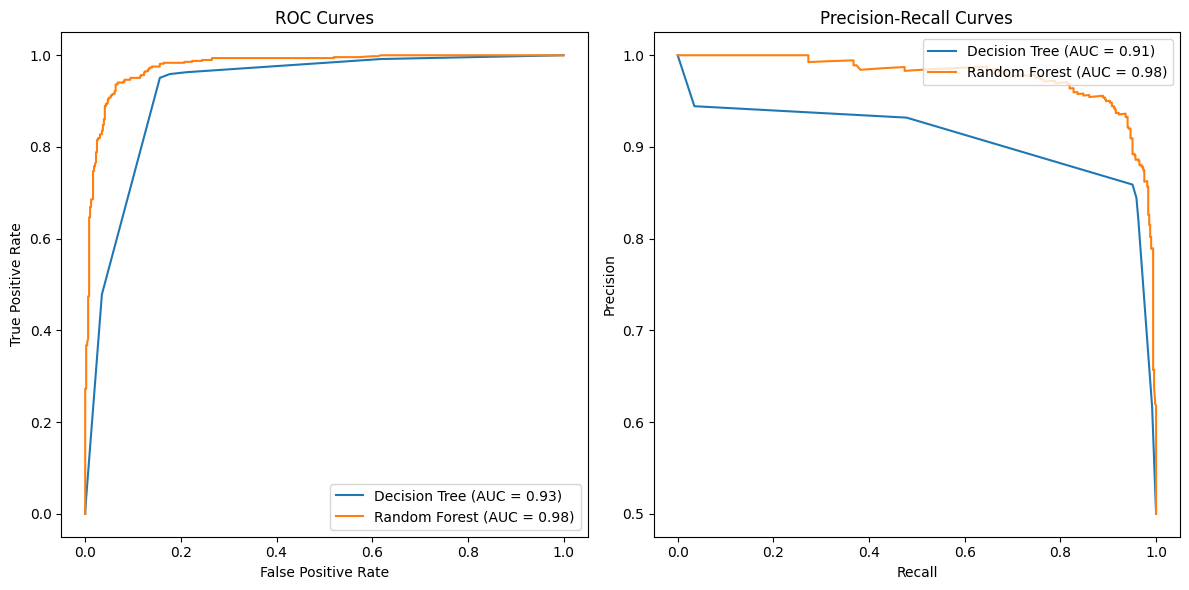


Hyperparameter tuning results for Decision Tree:
                                    params  mean_test_score  std_test_score
0   {'max_depth': None, 'max_features': 1}         0.855252        0.016215
1   {'max_depth': None, 'max_features': 2}         0.870648        0.014191
2   {'max_depth': None, 'max_features': 3}         0.856252        0.024123
3   {'max_depth': None, 'max_features': 4}         0.881988        0.032647
4   {'max_depth': None, 'max_features': 5}         0.868628        0.026518
..                                     ...              ...             ...
87   {'max_depth': 15, 'max_features': 19}         0.863463        0.026206
88   {'max_depth': 15, 'max_features': 20}         0.860391        0.024893
89   {'max_depth': 15, 'max_features': 21}         0.861427        0.027589
90   {'max_depth': 15, 'max_features': 22}         0.861406        0.028041
91   {'max_depth': 15, 'max_features': 23}         0.852176        0.031765

[92 rows x 3 columns]

Hyperparameter

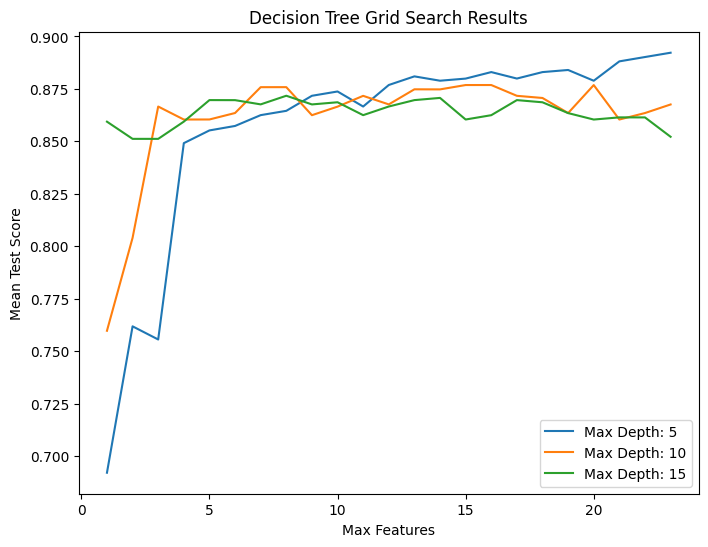


Grid search results for Random Forest:


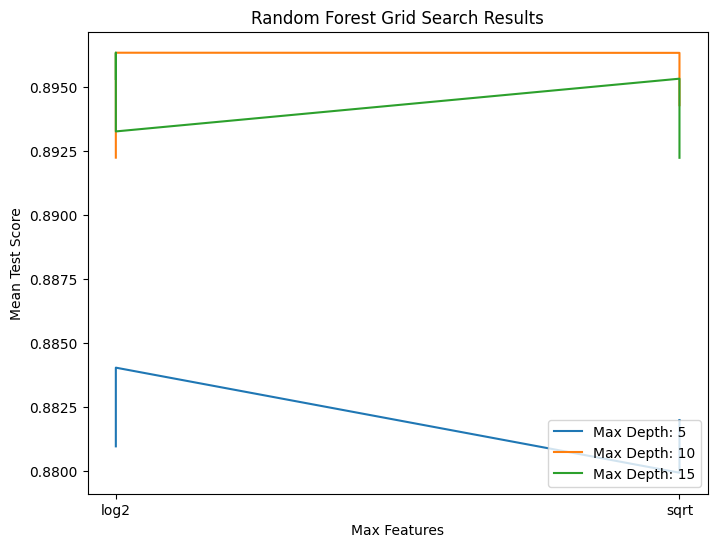

In [92]:
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, accuracy_score, auc, classification_report
)
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sb

# Define the models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machines': SVC(probability=True)
}

# Define evaluation metrics
metrics = {
    'Confusion Matrix': confusion_matrix,
    'Precision': precision_score,
    'Recall': recall_score,
    'Accuracy': accuracy_score,
    'F1 Score': f1_score,
    'Classification Report': classification_report
}

# Define hyperparameter grids for grid search
model_params = {
    'Decision Tree': {'max_depth': [None, 5, 10, 15], 'max_features': range(1, 24)},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 15], 'max_features': ['sqrt', 'log2']}
}

# Perform model evaluation and comparison
model_scores = {}
model_times = {}
model_accuracies = {}
grid_searches = {}

mutation_data_clean = pd.read_csv('data/mutation_data_clean.csv')

# Extract the data and labels
all_inputs = mutation_data_clean[['Gender', 'Age_at_diagnosis', 'Race', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC',
                                 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4',
                                 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']].values
all_labels = mutation_data_clean['Grade'].values

# Apply feature scaling
scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

repetitions = 10

for model_name, model in models.items():
    scores = {}
    start_time = time.time()

    # Hyperparameter tuning using GridSearchCV
    if model_name in model_params:
        param_grid = model_params[model_name]
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')
        grid_search.fit(all_inputs_scaled, all_labels)
        model = grid_search.best_estimator_
        print(f'Best parameters for {model_name}: {grid_search.best_params_}')
        grid_searches[model_name] = grid_search

    # Perform evaluation using cross-validation
    cv_scores = cross_val_score(model, all_inputs_scaled, all_labels, cv=StratifiedKFold(n_splits=10, shuffle=True))
    scores['Cross-Validation Mean'] = np.mean(cv_scores)
    scores['Cross-Validation STD'] = np.std(cv_scores)

    total_predictions = []
    for _ in range(repetitions):
        total_predictions = []  # Reset the list for each repetition

        # Split the data into training and testing sets
        training_inputs, testing_inputs, training_labels, testing_labels = train_test_split(all_inputs_scaled,
                                                                                            all_labels,
                                                                                            test_size=0.2,
                                                                                            stratify=all_labels)

        # Train the model
        model.fit(training_inputs, training_labels)

        # Predict on the testing set
        predictions = model.predict(testing_inputs)
        total_predictions.append(predictions)

    total_predictions = np.array(total_predictions)
    predictions_mean = np.mean(total_predictions, axis=0)
    
    scores['Accuracy'] = accuracy_score(testing_labels, predictions_mean.round().astype(int))
    scores['Precision'] = precision_score(testing_labels, predictions_mean.round().astype(int))
    scores['Recall'] = recall_score(testing_labels, predictions_mean.round().astype(int))
    scores['F1 Score'] = f1_score(testing_labels, predictions_mean.round().astype(int))
    scores['Confusion Matrix'] = confusion_matrix(testing_labels, predictions_mean.round().astype(int))
    scores['Classification Report'] = classification_report(testing_labels, predictions_mean.round().astype(int))
    
    model_scores[model_name] = scores
    model_times[model_name] = time.time() - start_time
    model_accuracies[model_name] = accuracy_score(testing_labels, predictions_mean.round().astype(int))

# Print the evaluation metrics for each model
for model_name, scores in model_scores.items():
    print(f'\nEvaluation metrics for {model_name}:')
    for metric_name, metric_func in metrics.items():
        if metric_name in scores:
            print(f'{metric_name}:')
            print(scores[metric_name])

# Compare the models based on accuracy
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.show()

# ROC curves and Precision-Recall curves
plt.figure(figsize=(12, 6))
for model_name, grid_search in grid_searches.items():
    model = grid_search.best_estimator_
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(all_inputs_scaled)[:, 1]
    else:
        y_score = model.decision_function(all_inputs_scaled)
    fpr, tpr, thresholds = roc_curve(all_labels, y_score)
    precision, recall, _ = precision_recall_curve(all_labels, y_score)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Hyperparameter tuning results
for model_name, grid_search in grid_searches.items():
    print(f'\nHyperparameter tuning results for {model_name}:')
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print(cv_results[['params', 'mean_test_score', 'std_test_score']])

# Grid search line plots visualization
for model_name, grid_search in grid_searches.items():
    print(f'\nGrid search results for {model_name}:')
    cv_results = pd.DataFrame(grid_search.cv_results_)
    param_grid = grid_search.param_grid

    plt.figure(figsize=(8, 6))
    for max_depth in param_grid['max_depth']:
        data = cv_results[cv_results['param_max_depth'] == max_depth]

        # Check if data is empty
        if not data.empty:
            data = data.sort_values(by='param_max_features')  # Sort data by max_features
            max_features = data['param_max_features']
            mean_test_scores = data['mean_test_score']
            plt.plot(max_features, mean_test_scores, label=f'Max Depth: {max_depth}')

    plt.xlabel('Max Features')
    plt.ylabel('Mean Test Score')
    plt.title(f'{model_name} Grid Search Results')
    plt.legend(loc='lower right')
    plt.show()



